# Project 5 Report
#### Ben Raivel

In [2]:
%load_ext autoreload
import pandas as pd
import HashTable as ht
import serial
import multitasking
import multiprocessing
import shutil
import time
import matplotlib.pyplot as plt

files = ['rc/reddit_comments_2008.txt', 'rc/reddit_comments_2009.txt', 'rc/reddit_comments_2010.txt', 
                'rc/reddit_comments_2011.txt', 'rc/reddit_comments_2012.txt', 'rc/reddit_comments_2013.txt',
                'rc/reddit_comments_2014.txt', 'rc/reddit_comments_2015.txt']

years = [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Multiprocessing
Below is code to count words across all files into a list of pandas DataFrames, one per input file (year), with columns for 'val' (raw count of word), 'key' (word), and 'freq' (frequency of word)

In [ ]:
# list to hold pandas df for each year
multi_df_list = []

# loop over list of file names
for f in files:

    # create a 'parent' hashtable
    multi_table = ht.HashTable()

    # open file
    file = open(f, 'r')

    # create a generator to iterate over 100,000 line blocks of file
    block_gen = multitasking.gen_block(file)

    # create a processing pool
    pool = multiprocessing.Pool()

    # non-blocking map of count words function onto generator
    sub_tables = pool.imap(multitasking.m_count_words, block_gen)

    # for each table returned by pool
    for t in sub_tables:

        # combine with the main table
        multi_table.combine(t)

    # convert hash table to dataframe and return
    multi_df_list.append(multi_table.to_df())


In [ ]:
for i in range(len(multi_df_list)):

    print('Top 10 words {year:d}'.format(year = years[i]))
    
    print(multi_df_list[i].head(10))

    print('\n')

### Performance Comparison
#### Serial Code

#### Multiprocessing Code

In [3]:
try:
    shutil.rmtree('logs')
except:
    pass
os.mkdir('logs')

# create a 'parent' hashtable
test_table = ht.HashTable()

# open file
file = open(files[0], 'r')

# create a generator to iterate over 100,000 line blocks of file
block_gen = multitasking.gen_block(file, time.time())

# create a processing pool
pool = multiprocessing.Pool()

# non-blocking map of count words function onto generator
sub_tables = pool.imap(multitasking.m_count_words, block_gen)

# for each table returned by pool
for t in sub_tables:

    # combine with the main table
    test_table.combine(t)

#### Plots
Generate a plot of words counted per process for multiprocessing word counting. The four (on my machine) worker processes count words in 100,000 line blocks, then merge them into the parent processes' table

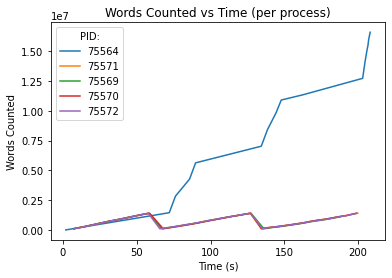

In [4]:
times = []
sizes = []
names = []

log_files = os.scandir('logs')

for lf in log_files:

    df = pd.read_csv(lf)

    times.append(df.get('time'))
    sizes.append(df.get('n_total'))
    names.append(lf.name.split('_')[0])

for i in range(len(times)):

    plt.plot(times[i], sizes[i], label = names[i])

plt.legend(title = 'PID:')
plt.title('Words Counted vs Time (per process)')
plt.xlabel('Time (s)')
plt.ylabel('Words Counted')
plt.show()